In [1]:
from IPython.core.display import display, HTML
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from astropy.io import ascii

from code import path
from code.auxiliary import *
import warnings
import astropy

display(HTML("<style>.container { width:100% !important; }</style>"))
warnings.filterwarnings("ignore", module='astropy.io.votable.tree')
%matplotlib inline

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


# Notebook structure

The notebook consists of four classes:

- catalogueProcessing
    - Used to perform queries and crossmatches
- Astrometry
    - Currently hosts functions for 
        - generating histograms
        - fitting gaussians
    - If HDbscan is implemented, it would go here.
- Photometry
    - Will have methods for making photometric cuts
- Visualization
    - Has methods for plotting, including
        - Plotting single columns
        - Plotting sources overlayed on an image
        - Plotting a gaussian fitted to a histogram generated from
          an arbitrary axis.
    - Will have method for plotting photometric cuts over the appropriate diagram






When catalogProcessing is instantiated, it queries gaia, 2mass, and allwise. This class also provides the ability to query any catalog availible from IRSA. __[More info here.](https://irsa.ipac.caltech.edu/docs/program_interface/TAP.html)__

Parallax for the cluster is optional and has units of milliarcseconds. If given, the radius is assumed to be physical (in pc), otherwise the radius is assumed to be angular (in degrees).

Initializing CatalogProcessing: ra=03h47m24s, dec=+24d07m00s, radius=0.5
Querying Gaia...
Creating query...
INFO: Query finished. [astroquery.utils.tap.core]
Retrieving results...
Results retrieved. 6687 sources detected.
Done querying Gaia!

Querying 2MASS...
Created TAP+ (v1.2.1) - Connection:
	Host: irsa.ipac.caltech.edu
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Creating query...
INFO: Query finished. [astroquery.utils.tap.core]
Retrieving results...
Results retrieved. 3376 sources detected.
Done querying 2MASS!

Querying AllWISE...
Created TAP+ (v1.2.1) - Connection:
	Host: irsa.ipac.caltech.edu
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Creating query...
INFO: Query finished. [astroquery.utils.tap.core]
Retrieving results...
Results retrieved. 8357 sources detected.
Done querying AllWISE!


Generating full table...
Extracting specified data columns...
Renaming columns...
Crossmatching Gaia with 2MASS...
Crossmatching Gaia with AllWISE...
Crossmatching 2MASS with AllWISE...
Crossm

code/CatalogProcessing.py:674: RuntimeWarning: invalid value encountered in sqrt
  v = np.sqrt(full_table.table['phot_g_n_obs']/full_table.table['phot_g_mean_flux_over_error'])
code/CatalogProcessing.py:680: RuntimeWarning: divide by zero encountered in divide
  d = 1000 / full_table.table['parallax']


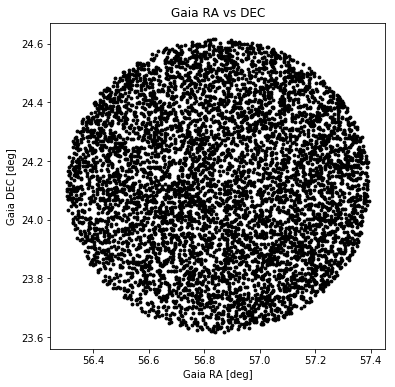

/home/reeves/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:538: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
code/auxiliary.py:431: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(fractional[good_data]),param_data[good_data])


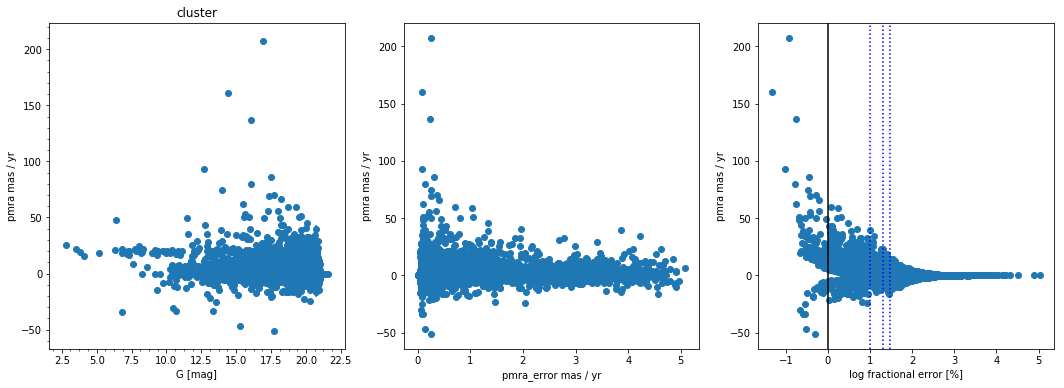

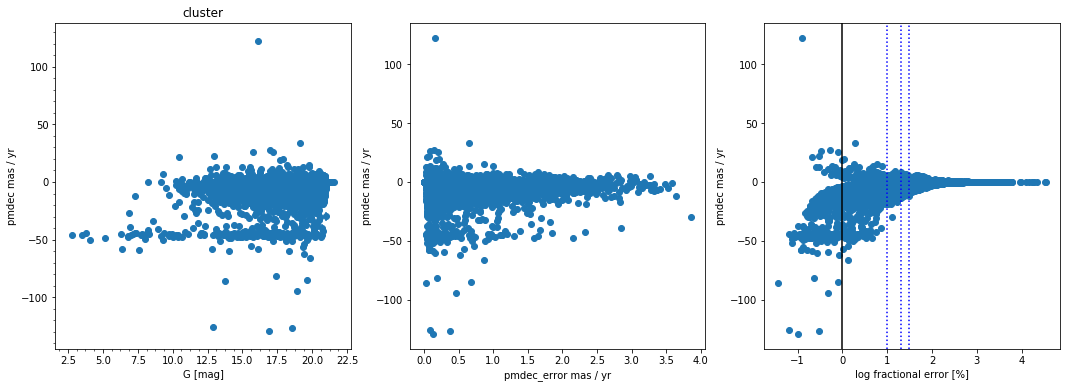

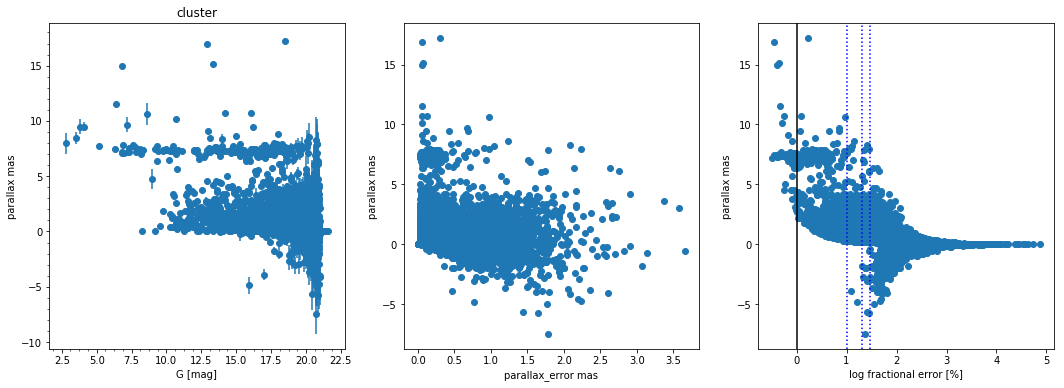

In [2]:
# Define region of interest parameters
ra_cen = "03h47m24s" # hour angle
dec_cen = "+24d07m00s" # degrees

#plx = 1.8481 # milliarcseconds, optional
rad = 0.5 # pc if plx is given, degrees if it is not

#coords = str(ra_cen) + "+" + str(dec_cen)

# Instantiates catalogProcessing:
#cat_pr = catalogProcessing(coords,radius=rad)
cat_pr = catalogProcessing(ra_cen, dec_cen, radius=rad)

# Builds the full data table:
full_table = cat_pr.generate_full_table(gen_small_table=True)
#full_table = Table.read('pleiades_data.dat',format='ascii')

# Instantiates the Visualization and Photometry classes
vis = Visualization(full_table, ra_cen, dec_cen)
phot = Photometry(full_table)

vis.plot_tables('Gaia RA vs DEC',[full_table],('gaia_ra','Gaia RA'),('gaia_dec','Gaia DEC'), squared=True)

# Generates diagnostic error plots:
#  proper motion, right ascension
vis.plot_error('pmra')
#  proper motion, declination
vis.plot_error('pmdec')
#  parallax
vis.plot_error('parallax')

Below cell generates a full table consisting of all sources in gaia, 2mass, and allwise at 1pc around the search coordinates (as specified upon instantiation of catalogueProcessing). If a source wasn't crossmatched with a particular catalogue, the column values of this catalogue will be masked.

set gen_small_table to False to return a table with all columns from all three surveys

Computing photometric variables...


code/auxiliary.py:804: RuntimeWarning: divide by zero encountered in divide
  M_g = [g + 5 - 5*np.log10(1000/p) for g,p in zip(self.full_table.table["phot_g_mean_mag"], self.full_table.table["parallax"])]
code/auxiliary.py:804: RuntimeWarning: divide by zero encountered in log10
  M_g = [g + 5 - 5*np.log10(1000/p) for g,p in zip(self.full_table.table["phot_g_mean_mag"], self.full_table.table["parallax"])]
code/auxiliary.py:804: RuntimeWarning: invalid value encountered in log10
  M_g = [g + 5 - 5*np.log10(1000/p) for g,p in zip(self.full_table.table["phot_g_mean_mag"], self.full_table.table["parallax"])]
code/auxiliary.py:804: RuntimeWarning: divide by zero encountered in double_scalars
  M_g = [g + 5 - 5*np.log10(1000/p) for g,p in zip(self.full_table.table["phot_g_mean_mag"], self.full_table.table["parallax"])]


Applying photometric cuts...
An error occurred while plotting diagnostics. This usually occurs because no sources passed a photometric cut.


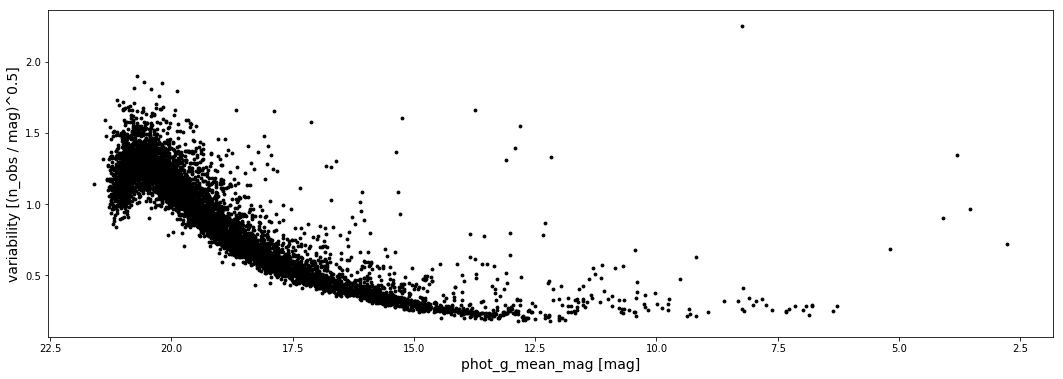

In [3]:
# Generates diagnostic plots of ra, dec, parallax, proper motion, and others.
vis.plot_diagnostics()
vis.plot("phot_g_mean_mag","variability",invert_x=True)

Below cell crossmatches the gaia table with the 2mass table. The xmatch radius is determined by looking at the errors of respective match (nearest neighbour) and selecting only objects that are closer than the combined error radii.

The method returns a list of indicies and distances that associates objects in catalogue1 with those in catalogue2.

In [4]:
#xmatch_res = cat_pr.xmatch(cat_pr.gaia, cat_pr.tmass, ["ra", "dec", "ra_error", "dec_error"], ["ra", "dec", "err_maj", "err_min"])
#print(xmatch_res)

plot_image_overlay gets images from the list of surveys passed to it and plots the sources from the list aux.Visualization was instantiated with, in this case gaia, superimposed on them.

I'll have to do something about overcrowding when there are many sources.

Adding coordinates of catalog objects...
Adding objects from gaia
Added gaia coords: 6687 objects added.
Adding objects from allwise
Added allwise coords: 8363 objects added.
Formatting coordinates...
Finding minimum and maximum RA and DEC...
Calculating field side length...
Retrieving images...
fetching surveys:
['DSS2 Red', '2MASS-J', 'WISE 4.6', 'WISE 22']
with radius:
1d05m18.353s


<IPython.core.display.Javascript object>


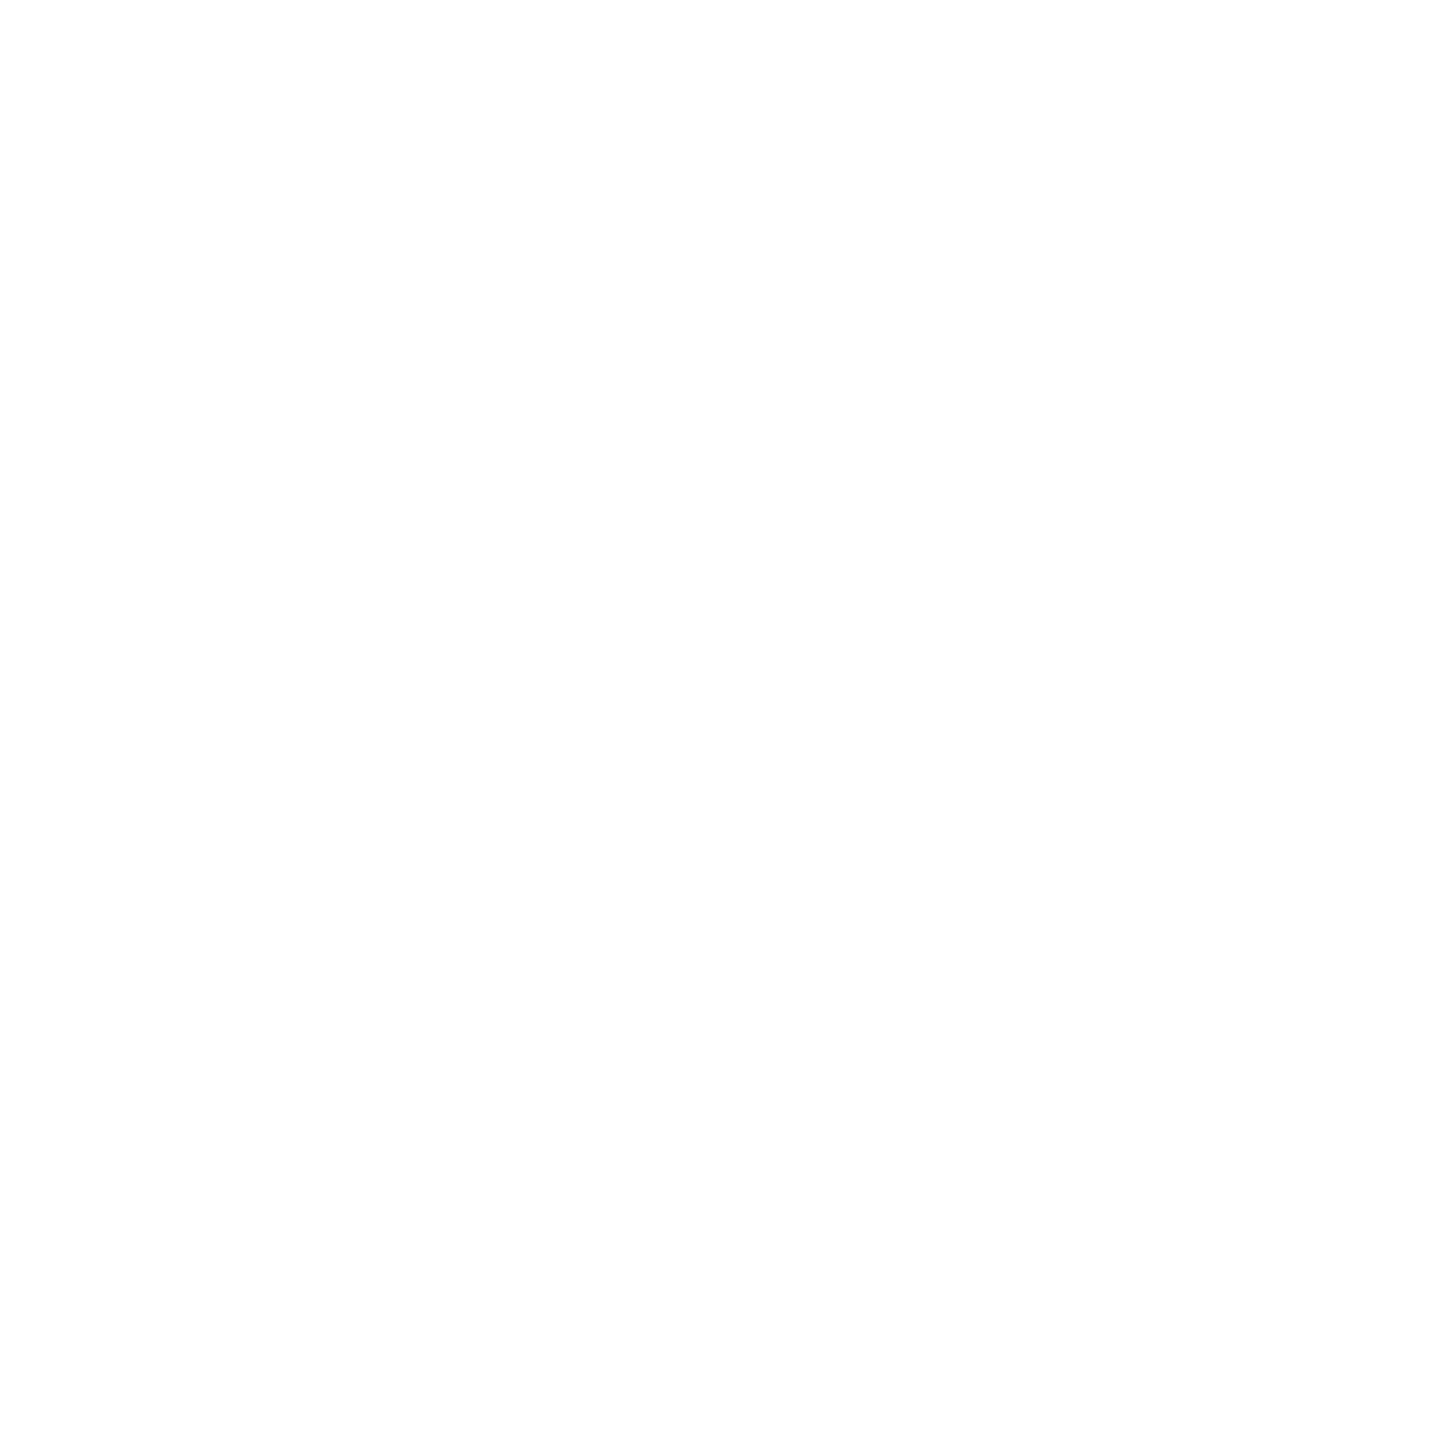

<IPython.core.display.Javascript object>


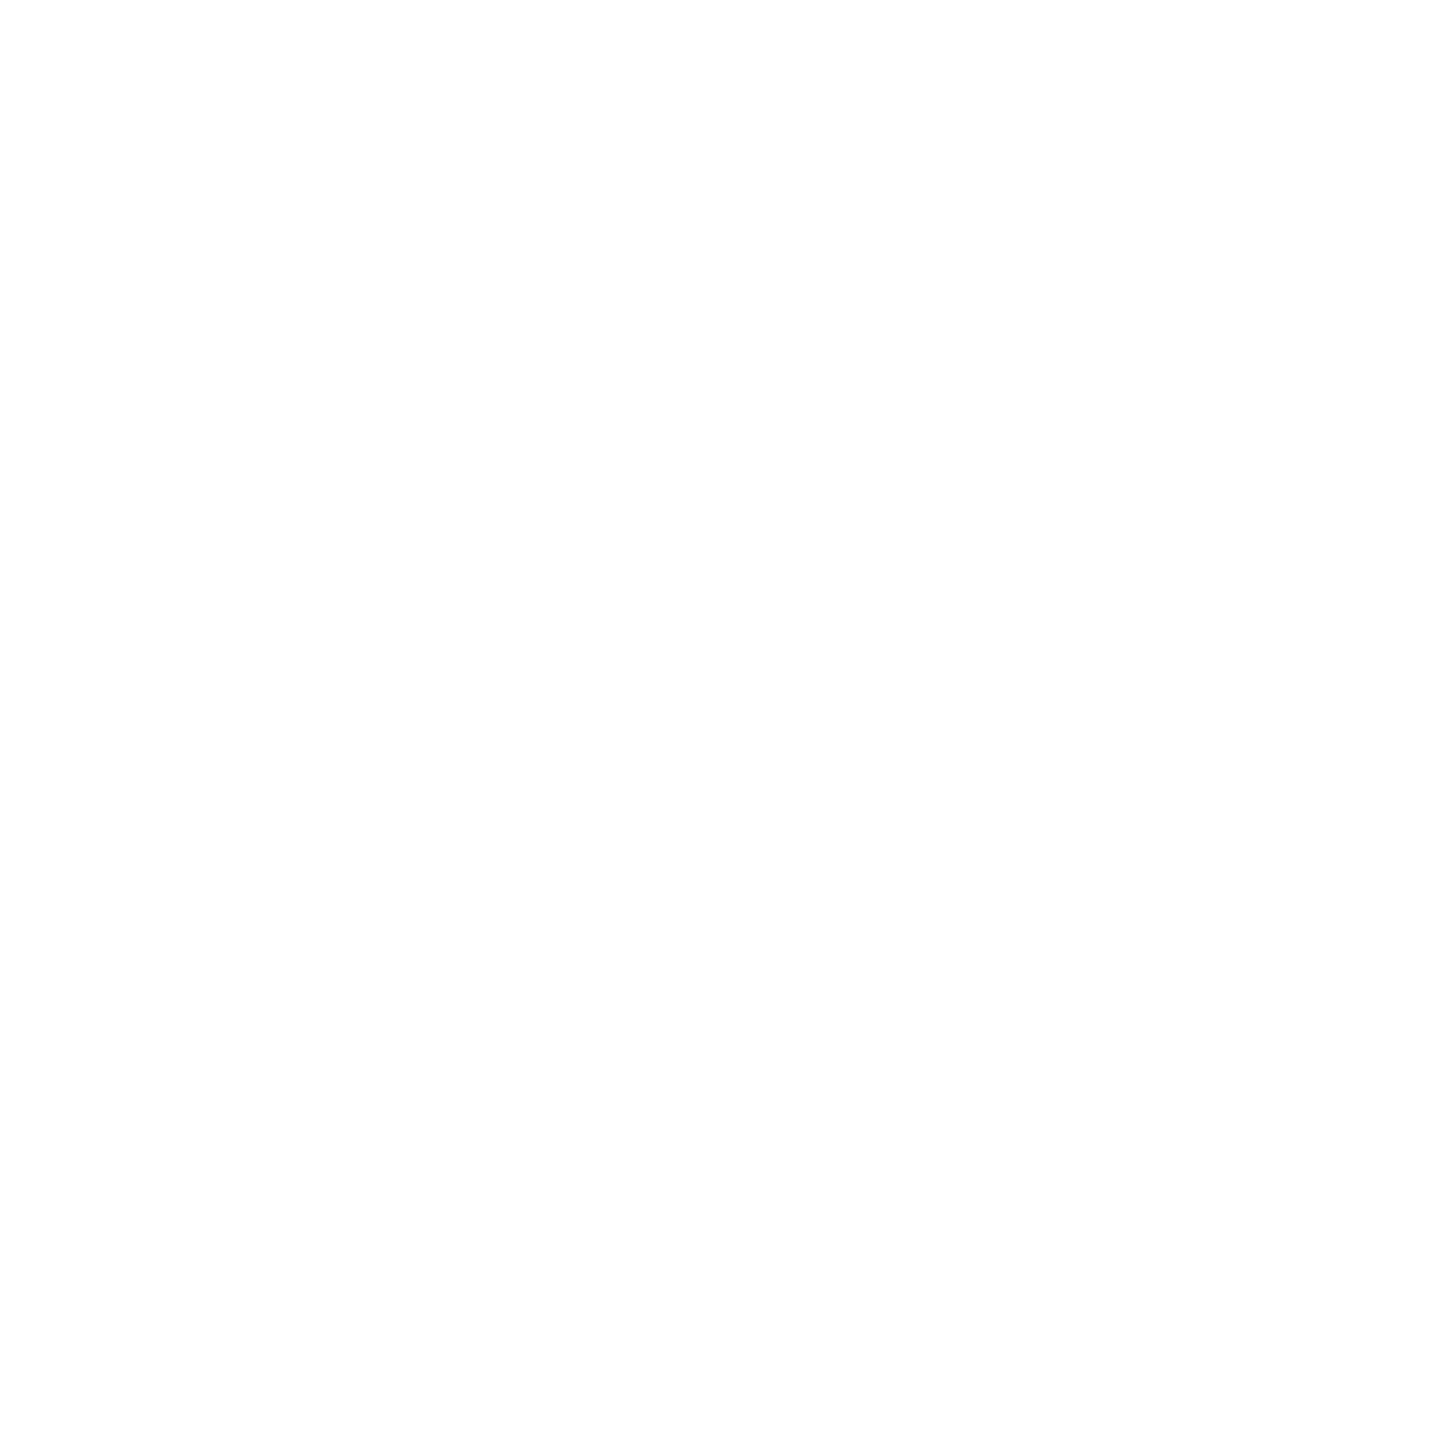

In [5]:
%matplotlib notebook
vis.plot_images(full_table, ['DSS2 Red', '2MASS-J', 'WISE 4.6', 'WISE 22'], cats_to_plot=["gaia", "allwise"])
#https://astroquery.readthedocs.io/en/latest/skyview/skyview.html

In [6]:
%matplotlib notebook
vis.plot_hist("parallax", "Parallax")
vis.plot_hist("pmra", "pm RA [mas/yr]")
vis.plot_hist("pmdec", "pm Dec [mas/yr]")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
vis.plot("gaia_ra", "gaia_dec", squared=True, invert_y=True)
vis.plot("pmra", "pmdec",xlim=(-30,30),ylim=(-30,30), squared=True, invert_y=True)
vis.plot("parallax", "parallax_error", xlim=(0,6))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
#%matplotlib inline
#redder, not_redder = phot.keep_reddest()
#vis_redder = Visualization(redder, ra_cen, dec_cen)
#vis_redder.plot_diagnostics()

In [9]:
#likely_disks, not_likely_disks = phot.keep_likely_disks()
#vis_likely_disks = Visualization(likely_disks, ra_cen, dec_cen)
#vis_likely_disks.plot_diagnostics()

The next cell runs HDBSCAN on the full_table input. It's set to return not more than 20 clusters - arbitrary, I'm still trying to figure out what works for this. It looks to me like the approach of using min_cluster_size may not be effective, but not using it currently gives me in excess of 200 clusters for this dataset, so another solution is needed.

On the plus side, even before applying any photometric cuts, the Pleiades are identified in orange in the plot below, which tells me that the algorithm is robust enough to tolerate some non-ideal behavior in terms of passing it data.

When running the algorithm twice, only removing the expected_clusters parameter for the second run, the number of detected clusters changes (in different ways depending on the dataset). I'm looking into ways to vary this and other parameters dynamically to achieve high-quality results.

In [10]:
ast = Astrometry(full_table)
candidates_table, cluster_membership_full = ast.identify_clusters(full_table, columns=("pmra","pmdec"), expected_clusters = 20, verbose=True)
#candidates_table, cluster_membership_full = ast.identify_clusters(full_table, columns=("pmra","pmdec"), verbose=True)

Organizing clustering data...
Columns in supplied data table:
['gaia_designation', 'gaia_ra', 'gaia_dec', 'ra_error', 'dec_error', 'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'phot_g_mean_mag', 'bp_rp', 'bp_g', 'g_rp', 'phot_g_n_obs', 'phot_g_mean_flux_over_error', 'phot_g_mean_flux_error', 'phot_g_mean_flux', 'phot_bp_mean_mag', 'phot_rp_mean_mag', '2mass_designation', '2mass_ra', '2mass_dec', 'err_maj', 'err_min', 'j_m', 'h_m', 'k_m', 'j_cmsig', 'h_cmsig', 'k_cmsig', 'k_snr', 'allwise_designation', 'allwise_ra', 'allwise_dec', 'sigra', 'sigdec', 'w1mpro', 'w2mpro', 'w3mpro', 'w4mpro', 'w1sigmpro', 'w2sigmpro', 'w3sigmpro', 'w4sigmpro', 'w4snr', 'variability', 'radial_distance']
Columns to be used for clustering analysis:
('pmra', 'pmdec')
Initializing data structures...
Selecting data...
Columns in dataset: 
2
Entries in dataset: 
6658
Calculating clusters...
Iterating minimum cluster size...
1%
Detected 4 clusters
Clustering calculation complete.


In [11]:
vis.plot_clusters(candidates_table.table, cluster_membership_full, "pmra", "pmdec", squared=True)

<IPython.core.display.Javascript object>

plotting cluster0


<IPython.core.display.Javascript object>

plotting cluster1


<IPython.core.display.Javascript object>

plotting cluster2


<IPython.core.display.Javascript object>

plotting cluster3


<IPython.core.display.Javascript object>